In [1]:
import numpy as np
from collections import defaultdict
import gzip
import matplotlib.pyplot as plt
import subprocess

import sys
sys.path.append("../utils")
from misc import load_chrom_sizes

In [2]:
# model sequence input length and prediction output length
in_window = 2114
out_window = 1000

In [3]:
# where we will dump the bed files this notebook makes
regions_out_dir = "regions_to_predict"
! mkdir -p regions_to_predict/

## Load + Preprocess the CLS Transcript Data

In [4]:
# the CLS data: transcript models stored in GTF format
# from https://github.com/guigolab/gencode-cls-master-table

main_gtf = "Hv3_masterTable_refined.gtf.gz"

In [6]:
def parse_compact_ids(compact_ids_str):
    # see the README at https://github.com/guigolab/gencode-cls-master-table
    # for how to translate the info in these strings
    
    seq_techs = []
    capture_status = []
    
    # could be a list of multiple ids
    compact_ids = compact_ids_str.split(",")
    
    for compact_id in compact_ids:
        # what sequencing technology found this transcript?
        if compact_id[7] == "O":
            seq_techs.append("ont")
        elif compact_id[7] == "P":
            seq_techs.append("pacBioSII")
        else:
            print("compact_id[7]", compact_id[7])

        # was transcript identified with or w/o capture strategy?
        if compact_id[8] == "P":
            capture_status.append("pre-capture")
        elif compact_id[8] == "C":
            capture_status.append("post-capture")
        else:
            print("compact_id[8]", compact_id[8])
            
    # collapse lists into strings to put as one entry in a TSV file
    seq_techs = ",".join(sorted(list(set(seq_techs))))
    capture_status = ",".join(sorted(list(set(capture_status))))

    return seq_techs, capture_status


def load_gtf(gtf_filepath, region_types_to_load = ["transcript"]):
    regions = defaultdict(lambda : [])
    
    if gtf_filepath.endswith(".gz"):
        f = gzip.open(gtf_filepath)
    else:
        f = open(gtf_filepath)
        
    for line in f:
        if gtf_filepath.endswith(".gz"):
            line = line.decode()
        
        if line.startswith("#"):
            continue  # skip header line
        
        chrom, _, label, start, end, _, strand = line.split()[:7]
        
        # label could be transcript/exon/etc.
        if label in region_types_to_load:
            # need to process the label field in each line
            
            # weird indexing is to remove quotes and ; around '"gene_name";'
            gene_name = line.split()[15][1:-2]  
            compact_ids = line.split()[25][1:-2]

            seq_techs, capture_status = parse_compact_ids(compact_ids)
            
            regions[label].append((chrom, start, end, strand, gene_name, seq_techs, capture_status))
            
    f.close()
    return regions


gtf_data = load_gtf(main_gtf)["transcript"]

In [7]:
### From each transcript model, get the actual TSS's coordinates

def define_TSSs(transcript_regions, chroms_to_keep = None, chroms_to_remove = ["chrM", "chrEBV"]):
    TSSs = []
    for region in transcript_regions:
        chrom, start, end, strand, support, seq_tech, capture_status = region
        
        if chroms_to_keep is not None:
            if chrom not in chroms_to_keep:
                continue
        if chroms_to_remove is not None:
            if chrom in chroms_to_remove:
                continue
        
        # if transcript on + strand, start coord is TSS
        # else if transcript on - strand, end coord is TSS
        if strand == "+":
            TSS = int(start)
        else:
            TSS = int(end)
        
        # need to convert into bed format from GTF format (1-index to 0-index)
        TSS_start, TSS_end = TSS - 1, TSS
        
        info = (chrom, str(TSS_start), str(TSS_end), strand, support, seq_tech, capture_status)
        TSSs.append(info)
        
    # for now, only collapse if literally all info is identical for multiple TSSs
    # then sort in bed-format order 
    TSSs = sorted(list(set(TSSs)), key = lambda l : (l[0], int(l[1]), l[3])) 
    return TSSs


TSSs_unmerged = define_TSSs(gtf_data)

In [8]:
def TSSs_overlap(TSS_info1, TSS_info2):
    # checks if two TSSs should be considered duplicates
    chroms_match = TSS_info1[0] == TSS_info2[0]
    positions_match = TSS_info1[1] == TSS_info2[1]
    strands_match = TSS_info1[3] == TSS_info2[3]
    return chroms_match and positions_match and strands_match


def combine_supports(supports):
    # When two TSSs are duplicates except for their supports,
    # this function is needed to figure out how to merge
    # the support type strings.
    
    support_options = ['cageOnlySupported','cagePolyASupported', 'noCageNoPolyASupported', 'polyAOnlySupported']
    assert all([support in support_options for support in supports]), supports
    
    if "cagePolyASupported" in supports:
        return "cagePolyASupported"
    elif "cageOnlySupported" in supports and "polyAOnlySupported" in supports:
        return "cagePolyASupported"
    elif "cageOnlySupported" in supports:
        return "cageOnlySupported"
    elif "polyAOnlySupported" in supports:
        return "polyAOnlySupported"
    else:
        return "noCageNoPolyASupported"
    

def merge_TSS_info(TSS_infos):
    # This function takes in a set of TSSs that have been
    # determined to be duplicates, and merges their info
    # so that they can just be one row in a data file.
    
    chrom, start, end, strand = TSS_infos[0][:4]
    
    all_supports = []
    all_seq_techs = []
    all_capture_statuses = []
    for TSS_info in TSS_infos:
        all_supports.extend(TSS_info[4].split(","))
        all_seq_techs.extend(TSS_info[5].split(","))
        all_capture_statuses.extend(TSS_info[6].split(","))
        
    all_supports = combine_supports(all_supports)
    all_seq_techs = ",".join(sorted(list(set(all_seq_techs))))
    all_capture_statuses = ",".join(sorted(list(set(all_capture_statuses))))
    
    return (chrom, start, end, strand, all_supports, all_seq_techs, all_capture_statuses)


def merge_same_TSSs(TSSs):
    # This function loops through all TSSs for all transcript models
    # and merges TSSs if they have the same genomic position (stranded),
    # combining support and capture info.
    
    # input list of TSSs must be sorted correctly first!
    assert all((TSSs[i][0], int(TSSs[i][1]), TSSs[i][3]) <= (TSSs[i+1][0], int(TSSs[i+1][1]), TSSs[i+1][3]) for i in range(len(TSSs) - 1))
    
    merged_TSSs = []
    TSSs_to_merge = []
    for index, TSS_info in enumerate(TSSs):
        # if two adjacent TSSs are actually duplicates, plan to merge them later
        if index < len(TSSs) - 1 and TSSs_overlap(TSS_info, TSSs[index + 1]):
            TSSs_to_merge.append(TSS_info)
            
        # If the current TSS we're looking at is not a duplicate
        # of the previous TSS, then we should merge the running group of duplicates.
        elif len(TSSs_to_merge) > 0:
            TSSs_to_merge.append(TSS_info)
            
            assert len(set([(tup[0], tup[1], tup[3]) for tup in TSSs_to_merge])) == 1, TSSs_to_merge
            
            # merge the TSSs that are a group a duplicates into one, then save
            merged_TSSs.append(merge_TSS_info(TSSs_to_merge))
            
            # reset
            TSSs_to_merge = []
        else:
            merged_TSSs.append(TSS_info)
            
    return merged_TSSs
            
    
TSSs = merge_same_TSSs(TSSs_unmerged)

In [9]:
# I checked this matched how many I got if I did everything above,
# but on the command line with bedtools
len(TSSs_unmerged), len(TSSs)

(840176, 614099)

In [10]:
# save TSSs (merged duplicates) to file

def write_to_bed(bed_filepath, bed_lines):
    to_write = "\n".join(["\t".join([str(i) for i in row]) for row in bed_lines])
    
    if bed_filepath.endswith(".gz"):
        with gzip.open(bed_filepath, "w") as f:
            f.write(to_write.encode())
    else:
        with open(bed_filepath, "w") as f:
            f.write(to_write)
            
write_to_bed(regions_out_dir + "/all_TSSs.bed.gz", TSSs)

In [11]:
# also save TSSs in files per-chromosome, if that helps predictions later

all_chromosomes = sorted(list(set([TSS[0] for TSS in TSSs])))

for chromosome in all_chromosomes:
    TSS_subset = [TSS for TSS in TSSs if TSS[0] == chromosome]
    
    write_to_bed(regions_out_dir + "/TSSs." + chromosome + ".bed.gz", TSS_subset)

## TSS Statistics

In [12]:
# How many (unique) TSSs on each chromosome?

for chrom in sorted(list(set([TSS[0] for TSS in TSSs]))):
    print(chrom, sum([1 for TSS in TSSs if TSS[0] == chrom]))

GL000008.2 81
GL000009.2 43
GL000194.1 132
GL000195.1 246
GL000205.2 171
GL000213.1 7
GL000214.1 57
GL000218.1 110
GL000219.1 140
GL000220.1 42
GL000221.1 75
GL000224.1 14
GL000225.1 4
KI270442.1 2
KI270706.1 51
KI270710.1 1
KI270711.1 10
KI270712.1 19
KI270713.1 76
KI270714.1 15
KI270717.1 2
KI270718.1 6
KI270719.1 17
KI270720.1 4
KI270721.1 97
KI270722.1 6
KI270725.1 1
KI270726.1 25
KI270727.1 45
KI270728.1 300
KI270731.1 66
KI270733.1 33
KI270734.1 65
KI270741.1 19
KI270742.1 124
KI270743.1 40
KI270744.1 37
KI270745.1 16
KI270746.1 9
KI270748.1 9
KI270749.1 3
KI270750.1 15
KI270751.1 47
KI270753.1 3
KI270754.1 3
KI270755.1 1
chr1 60041
chr10 24213
chr11 31374
chr12 30549
chr13 12801
chr14 21588
chr15 20384
chr16 23779
chr17 31390
chr18 10512
chr19 33377
chr2 45815
chr20 15287
chr21 9127
chr22 14455
chr3 32288
chr4 24550
chr5 29468
chr6 35247
chr7 33561
chr8 23486
chr9 26711
chrX 20196
chrY 1611


In [14]:
# How many TSSs have each of the support type labels?
# (some TSSs may have multiple labels??)

# Before merging duplicate TSSs:

transcript_support = [line[4] for line in TSSs_unmerged]
for support_option in ['cageOnlySupported','cagePolyASupported', 'noCageNoPolyASupported', 'polyAOnlySupported']:
    print(support_option, np.sum(np.array(transcript_support) == support_option))

cageOnlySupported 44580
cagePolyASupported 476470
noCageNoPolyASupported 23895
polyAOnlySupported 295231


In [15]:
# After merging duplicate TSSs:

transcript_support = [line[4] for line in TSSs]
for support_option in ['cageOnlySupported','cagePolyASupported', 'noCageNoPolyASupported', 'polyAOnlySupported']:
    print(support_option, np.sum(np.array(transcript_support) == support_option))

cageOnlySupported 20745
cagePolyASupported 310202
noCageNoPolyASupported 18689
polyAOnlySupported 264463


In [16]:
# How many TSSs from either sequencing technology?

# Before merging duplicate TSSs:

seq_techs = [line[5] for line in TSSs_unmerged]
for seq_tech_option in set(seq_techs):
    print(seq_tech_option, np.sum(np.array(seq_techs) == seq_tech_option))

pacBioSII 178197
ont 555723
ont,pacBioSII 106256


In [17]:
# After merging duplicate TSSs:

seq_techs = [line[5] for line in TSSs]
for seq_tech_option in set(seq_techs):
    print(seq_tech_option, np.sum(np.array(seq_techs) == seq_tech_option))

pacBioSII 77243
ont 389924
ont,pacBioSII 146932


In [18]:
# How many TSSs are pre- vs. post-capture?
# (Some labeled as both??)

# Before merging duplicate TSSs:

capture_stats = [line[6] for line in TSSs_unmerged]
for capture_option in set(capture_stats):
    print(capture_option, np.sum(np.array(capture_stats) == capture_option))

pre-capture 320880
post-capture,pre-capture 79760
post-capture 439536


In [19]:
# After merging duplicate TSSs:

capture_stats = [line[6] for line in TSSs]
for capture_option in set(capture_stats):
    print(capture_option, np.sum(np.array(capture_stats) == capture_option))

post-capture,pre-capture 114795
post-capture 301189
pre-capture 198115


## Define Windows Around TSSs To Generate Predictions In

In [20]:
# this file came from running the ucsc_tools util on GENCODE's latest hg38 fasta file
chrom_sizes = {k : v for (k,v) in load_chrom_sizes("genome/hg38.gencode_naming.chrom.sizes")}

In [25]:
# For every TSS, draw a window of sequence you will make predictions for;
# then merge overlapping windows so you don't apply the model to the same promoter 20 times


# "extend_by" = around each TSS, how large of a window to consider
# (window_len = 2 * extend_by)
def make_windows_around_TSSs(TSSs, extend_by = 500, chromosome_boundary_pad = (in_window - out_window) // 2):
    # chromosome_boundary_pad is there because when we want to predict near end of chromosome,
    # we need longer sequence input to the model than the profile length it will output
    
    # extend windows +/- extend_by around each TSS
    TSS_windows = []
    for TSS in TSSs:
        chrom, start, end, strand, support_type, seq_tech, capture_status = TSS

        # because we already convert into BED coords above, un-adjust by 1 here
        window_start = max(chromosome_boundary_pad, int(start) - extend_by + 1)
        window_end = min(chrom_sizes[chrom] - chromosome_boundary_pad, int(end) + extend_by)
        
        # if we're on the boundary of a chromosome, just pick the first/last window
        # (enforces that all windows are the same size)
        if window_start == chromosome_boundary_pad:
            window_end = out_window + chromosome_boundary_pad
        
        if window_end == chrom_sizes[chrom] - chromosome_boundary_pad:
            window_start = chrom_sizes[chrom] - chromosome_boundary_pad - out_window
        
        #if chrom == "KI270718.1":
        #    print(chrom, start, end, window_start, window_end, chrom_sizes[chrom] - chromosome_boundary_pad)
        
        assert window_end <= chrom_sizes[chrom], (chrom, chrom_sizes[chrom], window_end, start)
        assert window_end - window_start == extend_by * 2 or window_end - window_start == out_window, (window_start, window_end) 

        window_info = (chrom, str(window_start), str(window_end), strand)
        TSS_windows.append(window_info)
    
    return TSS_windows
    
    
TSS_windows_unmerged = make_windows_around_TSSs(TSSs)

In [26]:
# save the windows we will use into a BED file;
# merge overlaps to avoid re-predicting in the same region repeatedly
# (we will tile predictions across regions anyways)

def write_regions_to_bed_file(regions, filepath):
    regions = sorted(regions, key = lambda region : (region[0], int(region[1])))
    if filepath.endswith(".gz"):
        with gzip.open(filepath, "w") as f:
            for region_info in regions:
                line = "\t".join([str(thing) for thing in region_info]) + "\n"
                f.write(line.encode())
    else:
        with open(filepath, "w") as f:
            for region_info in regions:
                line = "\t".join([str(thing) for thing in region_info]) + "\n"
                f.write(line)
                
write_regions_to_bed_file(TSS_windows_unmerged, regions_out_dir + "/TSS_windows.premerge.bed.gz")

In [27]:
def run_bedtools_merge(filepath_i, dest_filepath, other_args=[]):
    cmd = ["bedtools", "merge"]
    cmd += ["-i", filepath_i]
    for arg in other_args:
        cmd += [arg]
        
    print("Running " + " ".join(cmd))
    with open(dest_filepath, "w") as outf:
        if dest_filepath.endswith(".gz"):
            bedtools = subprocess.Popen(cmd, stdout=subprocess.PIPE)
            # pipe to gzip
            subprocess.call(('gzip', '-nc'), stdin=bedtools.stdout, stdout=outf)
            bedtools.wait()
        else:
            subprocess.call(cmd, stdout=outf)

run_bedtools_merge(regions_out_dir + "/TSS_windows.premerge.bed.gz",
                   regions_out_dir + "/TSS_windows.merged.bed.gz",
                   other_args=["-c", "4", "-o", "distinct"])

Running bedtools merge -i regions_to_predict/TSS_windows.premerge.bed.gz -c 4 -o distinct


In [28]:
for chromosome in all_chromosomes:
    TSS_window_subset = [window for window in TSS_windows_unmerged if window[0] == chromosome]
    
    if len(TSS_window_subset) > 1:
        write_to_bed(regions_out_dir + "/TSS_windows.premerge." + chromosome + ".bed.gz", TSS_window_subset)
    
        run_bedtools_merge(regions_out_dir + "/TSS_windows.premerge." + chromosome + ".bed.gz",
                       regions_out_dir + "/TSS_windows.merged." + chromosome + ".bed.gz",
                       other_args=["-c", "4", "-o", "distinct"])
    else:
        print(regions_out_dir + "/TSS_windows.merged." + chromosome + ".bed.gz")
        write_to_bed(regions_out_dir + "/TSS_windows.merged." + chromosome + ".bed.gz", TSS_window_subset)

Running bedtools merge -i regions_to_predict/TSS_windows.premerge.GL000008.2.bed.gz -c 4 -o distinct
Running bedtools merge -i regions_to_predict/TSS_windows.premerge.GL000009.2.bed.gz -c 4 -o distinct
Running bedtools merge -i regions_to_predict/TSS_windows.premerge.GL000194.1.bed.gz -c 4 -o distinct
Running bedtools merge -i regions_to_predict/TSS_windows.premerge.GL000195.1.bed.gz -c 4 -o distinct
Running bedtools merge -i regions_to_predict/TSS_windows.premerge.GL000205.2.bed.gz -c 4 -o distinct
Running bedtools merge -i regions_to_predict/TSS_windows.premerge.GL000213.1.bed.gz -c 4 -o distinct
Running bedtools merge -i regions_to_predict/TSS_windows.premerge.GL000214.1.bed.gz -c 4 -o distinct
Running bedtools merge -i regions_to_predict/TSS_windows.premerge.GL000218.1.bed.gz -c 4 -o distinct
Running bedtools merge -i regions_to_predict/TSS_windows.premerge.GL000219.1.bed.gz -c 4 -o distinct
Running bedtools merge -i regions_to_predict/TSS_windows.premerge.GL000220.1.bed.gz -c 4 -o

### Check That The Windows Look Right

In [29]:
def load_coords(bed_file):
    # loads bed file into list of regions, 1 element in list = 1 row of file
    lines = []
    if bed_file.endswith(".gz"):
        with gzip.open(bed_file) as f:
            lines = [line.decode().split() for line in f]
    else:
        with open(bed_file) as f:
            lines = [line.split() for line in f]
    
    coords = [(line[0], int(line[1]), int(line[2]), line[3]) for line in lines]
    return np.array(coords, dtype=object)


TSS_windows = load_coords(regions_out_dir + "/TSS_windows.merged.bed.gz")

In [31]:
print(len(TSS_windows))

109456


In [32]:
# How many (unique) TSSs on each chromosome?

for chrom in sorted(list(set([TSS_window[0] for TSS_window in TSS_windows]))):
    print(chrom, sum([1 for TSS_window in TSS_windows if TSS_window[0] == chrom]))

GL000008.2 7
GL000009.2 9
GL000194.1 13
GL000195.1 22
GL000205.2 16
GL000213.1 2
GL000214.1 10
GL000218.1 9
GL000219.1 18
GL000220.1 12
GL000221.1 9
GL000224.1 4
GL000225.1 1
KI270442.1 2
KI270706.1 16
KI270710.1 1
KI270711.1 6
KI270712.1 6
KI270713.1 8
KI270714.1 6
KI270717.1 2
KI270718.1 4
KI270719.1 9
KI270720.1 2
KI270721.1 10
KI270722.1 5
KI270725.1 1
KI270726.1 8
KI270727.1 14
KI270728.1 49
KI270731.1 19
KI270733.1 12
KI270734.1 26
KI270741.1 2
KI270742.1 18
KI270743.1 7
KI270744.1 19
KI270745.1 5
KI270746.1 3
KI270748.1 4
KI270749.1 2
KI270750.1 2
KI270751.1 9
KI270753.1 2
KI270754.1 3
KI270755.1 1
chr1 10023
chr10 5024
chr11 5087
chr12 5260
chr13 2808
chr14 3573
chr15 3676
chr16 4018
chr17 4902
chr18 2355
chr19 4494
chr2 8828
chr20 2837
chr21 1593
chr22 2354
chr3 6170
chr4 5065
chr5 5872
chr6 6213
chr7 5751
chr8 4615
chr9 4779
chrX 3376
chrY 368


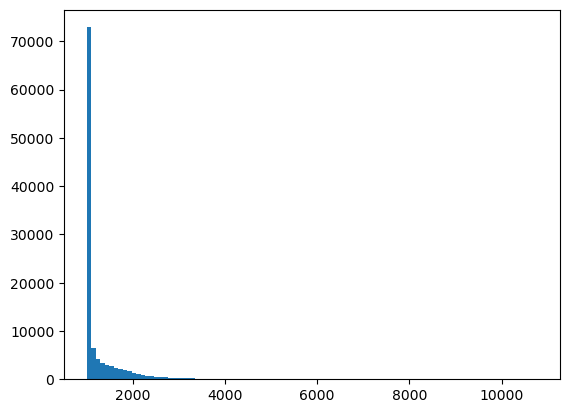

1000


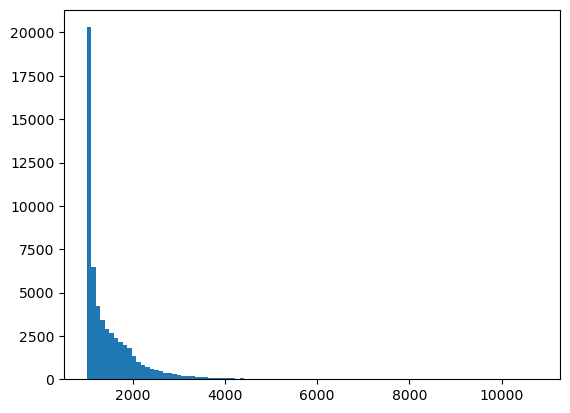

In [33]:
window_lens = [window[2] - window[1] for window in TSS_windows]
plt.hist(window_lens, bins=100)
plt.show()

print(min(window_lens))

window_lens = [window[2] - window[1] for window in TSS_windows if window[2] - window[1] > 1000]
plt.hist(window_lens, bins=100)
plt.show()

In [34]:
# I checked in the genome browser and these look legit

for window in TSS_windows:
    if window[2] - window[1] > 5000:
        print(window, window[2] - window[1])

['chr1' 180431 189089 '+,-'] 8658
['chr1' 628580 634748 '+,-'] 6168
['chr1' 1427994 1436125 '+,-'] 8131
['chr1' 3059643 3066059 '+,-'] 6416
['chr1' 8199855 8205002 '+,-'] 5147
['chr1' 12615363 12620931 '+,-'] 5568
['chr1' 25903622 25908970 '+,-'] 5348
['chr1' 26427016 26432903 '+,-'] 5887
['chr1' 54401428 54407920 '+,-'] 6492
['chr1' 63319253 63325301 '+,-'] 6048
['chr1' 85576101 85583618 '+,-'] 7517
['chr1' 121047939 121053157 '+,-'] 5218
['chr1' 143881880 143887045 '+,-'] 5165
['chr1' 148010845 148016741 '+,-'] 5896
['chr1' 155209827 155215431 '+,-'] 5604
['chr1' 155231309 155237356 '+,-'] 6047
['chr1' 155315802 155325022 '+,-'] 9220
['chr1' 182387933 182393921 '+,-'] 5988
['chr1' 226060590 226066677 '+,-'] 6087
['chr1' 229429855 229435405 '+,-'] 5550
['chr1' 234956695 234965723 '+,-'] 9028
['chr10' 8049276 8055188 '+,-'] 5912
['chr10' 52312649 52318715 '+,-'] 6066
['chr10' 75400462 75405525 '+,-'] 5063
['chr11' 306421 311706 '+,-'] 5285
['chr11' 1661077 1667303 '+,-'] 6226
['chr11' 

In [ ]:
# Done!